# Выбор локации для скважины

<a id='task'></a>
## Постановка задачи

**Тема проекта:** Построение модели для определения региона, где добыча нефти принесёт наибольшую прибыль.

### Назначение

**Цели проекта:** 
- Проанализировать характеристики для скважин в избранном регионе: качество нефти и объём её запасов;
- Построить модель для предсказания объёма запасов в новых скважинах;
- Выбрать скважины с самыми высокими оценками значений;
- Определить регион с максимальной суммарной прибылью отобранных скважин.

### Структура проекта
1. [Постановка задачи][1]
    1. Назначение
    2. Структура проекта
    3. Описание данных
2. [Загрузка данных][2]
3. [Предобработка данных][3]
4. [Исследовательский анализ данных][4]
    1. [Регион 0][4.1]
    2. [Регион 1][4.2]
    3. [Регион 2][4.3]
5. [Обучение моделей][5]
6. [Расчет прибыли][6]
    1. [Регион 0][6.1]
    2. [Регион 1][6.2]
    3. [Регион 2][6.3]
7. [Общие выводы][7]

[1]:#task
[2]:#general
[3]:#preprocess
[4]:#research
[4.1]:#reg0
[4.2]:#reg1
[4.3]:#reg2
[5]:#mod
[6]:#prof
[6.1]:#reg00
[6.2]:#reg01
[6.3]:#reg02
[7]:#fin

### Описание данных
Данные геологоразведки трёх регионов находятся в файлах: 
- `/datasets/geo_data_0.csv`.
- `/datasets/geo_data_1.csv`.
- `/datasets/geo_data_2.csv`.

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

<a id='general'></a>
## Загрузка данных

Подготовка к работе с данными: загружаем библиотеки.

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import os
import sklearn
import math

try:
    import phik
except:
    !pip install phik
    import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# загружаем классы для подготовки данных
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# библиотеки для графиков
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RANDOM_STATE = 52
TEST_SIZE = 0.25

In [3]:
# подготовка для графиков
palette = ["#F72585", "#4361EE",
           "#b5179e", "#4CC9F0", 
           "#7209B7", "#3A0CA3"]
sns.set(rc={'figure.figsize':(7, 6)},
        palette=palette, 
        font_scale=0.95)
sns.set_style(rc = {'axes.facecolor': '#e9e9f0'})

Считываем датафреймы.

In [4]:
# функция считывания датафрейма
def read_dfs(path, name, sep):
    for i in path:
        if os.path.exists(i+name):
            return pd.read_csv(i+name, sep=sep[0], decimal=sep[1])
    return print('File not found')

In [5]:
# записываем возможные пути
paths = ['/datasets/', 
         'C:\\Users\\Admin\\YandexDisk\\']
# разделение данных
sep=[',', '.']

df_name = 'geo_data_0.csv'
geo_data_0 = read_dfs(paths, df_name, sep)

df_name = 'geo_data_1.csv'
geo_data_1 = read_dfs(paths, df_name, sep)

df_name = 'geo_data_2.csv'
geo_data_2 = read_dfs(paths, df_name, sep)

Проверим данные.

In [6]:
# функция вывода информации о датафреймах
def df_info(df):
    print(df.info())
    print(df.head())

In [7]:
df_array = [geo_data_0, geo_data_1, geo_data_2]

for elm in df_array:
    df_info(elm)
    print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-nu

**Вывод:** загружены три датафрейма с 5-ю столбцами и 100 000 записей, пропусков нет, типы данных правильные.

<a id='preprocess'></a>
## Предобработка данных

Проверим данные на наличие явных дубликатов.

In [8]:
print('Кол-во дубликатов в geo_data_0:', 
      geo_data_0.duplicated().sum())
print('Кол-во дубликатов в geo_data_1:', 
      geo_data_1.duplicated().sum())
print('Кол-во дубликатов в geo_data_2:', 
      geo_data_2.duplicated().sum())

Кол-во дубликатов в geo_data_0: 0
Кол-во дубликатов в geo_data_1: 0
Кол-во дубликатов в geo_data_2: 0


Явных дубликатов нет, проверим наличие неявных дубликатов.

In [9]:
print('Кол-во дубликатов в "id" geo_data_0:', 
      geo_data_0['id'].duplicated().sum())
print('Доля дубликатов от общих данных:',
    geo_data_0['id'].duplicated().sum()/len(geo_data_0)) 
print()
print('Кол-во дубликатов в "id" geo_data_1:', 
      geo_data_1['id'].duplicated().sum())
print('Доля дубликатов от общих данных:',
    geo_data_1['id'].duplicated().sum()/len(geo_data_1)) 
print()
print('Кол-во дубликатов в "id" geo_data_2:', 
      geo_data_2['id'].duplicated().sum())
print('Доля дубликатов от общих данных:',
    geo_data_2['id'].duplicated().sum()/len(geo_data_2)) 

Кол-во дубликатов в "id" geo_data_0: 10
Доля дубликатов от общих данных: 0.0001

Кол-во дубликатов в "id" geo_data_1: 4
Доля дубликатов от общих данных: 4e-05

Кол-во дубликатов в "id" geo_data_2: 4
Доля дубликатов от общих данных: 4e-05


В данных присутствуют неявные дубликаты - повторяются `id` некоторых скажин. Доля повторяющихся записей очень мала, поэтому удаляем дубликаты.

In [10]:
geo_data_0 = geo_data_0.drop_duplicates(subset='id')
geo_data_1 = geo_data_1.drop_duplicates(subset='id')
geo_data_2 = geo_data_2.drop_duplicates(subset='id')

geo_data_0.shape, geo_data_1.shape, geo_data_2.shape

((99990, 5), (99996, 5), (99996, 5))

**Вывод:** в данных нет явных дубликатов, но обнаружены и удалены неявные дубликаты в столбце `id`.

<a id='research'></a>
## Исследовательский анализ данных

In [11]:
# функция построения графиков для
# категориальных признаков
def hist_box(df):
    # выбор числовых столбцов
    colmns = df.select_dtypes(include=['number']).columns

    # размер графика
    plots = len(colmns)
    plt.figure(figsize=(10, 5 * plots))

    # построение гистограммы и боксплота для каждого столбца
    for i, col in enumerate(colmns):
        # гистограмма
        plt.subplot(plots, 2, 2*i + 1)
        sns.histplot(data=df[col].values)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # ящик с усами
        plt.subplot(plots, 2, 2*i + 2)
        sns.boxplot(x=df[col].values)
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

In [12]:
# функция матрицы корреляции
def phik_corr(df):
    phik_x = df.drop(['id', 'product'], axis=1)
    phik_y = df['product']
    interval_cols = df.select_dtypes(include=['number'])\
    .columns
    
    # считаем корреляции на тренировочной выборке
    phik_overview = phik_matrix(phik_x.join(phik_y), 
                            interval_cols=interval_cols) 
    
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, 
        color_map='Greens',
        title=r'correlation $\phi_K$',
        fontsize_factor=1.5,
        figsize=(6, 6)
    )

<a id='reg0'></a>
### Регион 0

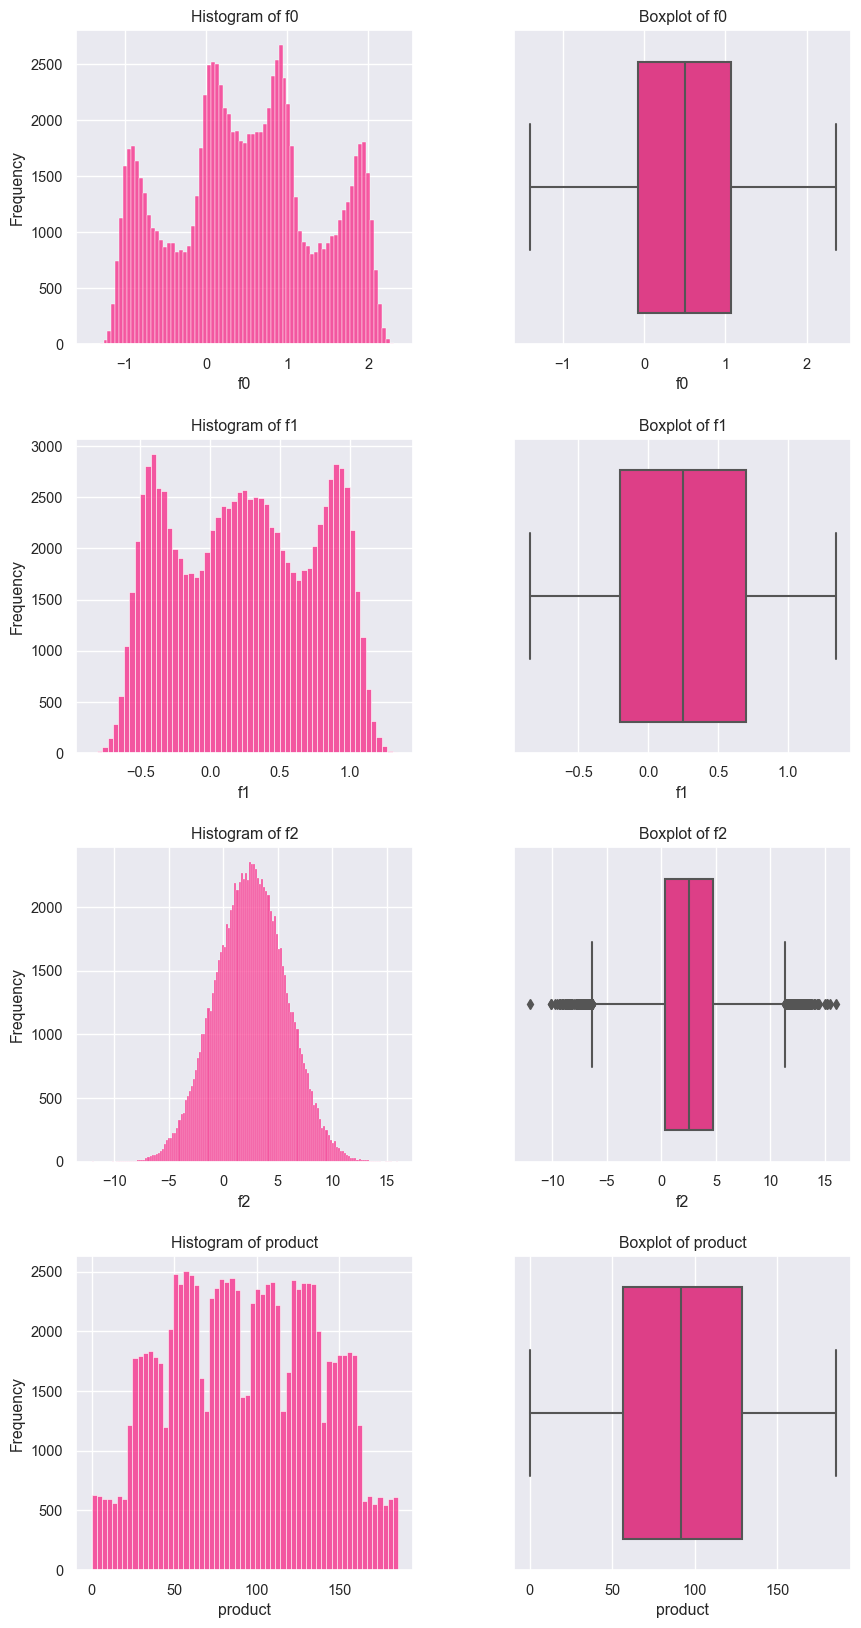

In [13]:
hist_box(geo_data_0)

В признаке `f2` есть выбросы, только `f2` распределен нормально.

In [14]:
geo_data_0.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,99990.0,0.500454,0.871844,-1.408605,-0.072572,0.502405,1.073626,2.362331
f1,99990.0,0.250141,0.504430,-0.848218,-0.200877,0.250252,0.700640,1.343769
f2,99990.0,2.502629,3.248149,-12.088328,0.287784,2.515969,4.715035,16.003790
product,99990.0,92.499684,44.288304,0.000000,56.497069,91.847928,128.563699,185.364347


Статистика целевого признака `product` - объём запасов в скважине (тыс. баррелей):
- Среднее: 92.50
- Медиана: 91.85
- Минимальное: 0.0
- Максимальное: 185.36

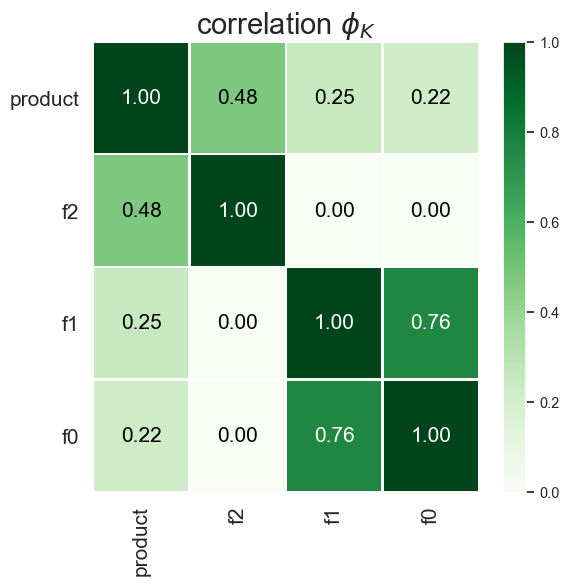

In [15]:
phik_corr(geo_data_0)

Мультиколлинеарность - сильная линейная взаимосвязь между входными признаками. О ней говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. Таких коэффициентов в данной выборке нет, значит, **мультиколлинеарности нет.**

Больше всего целевой признак коррелирует с `f2`, коэффициент корреляции равен 0.48.

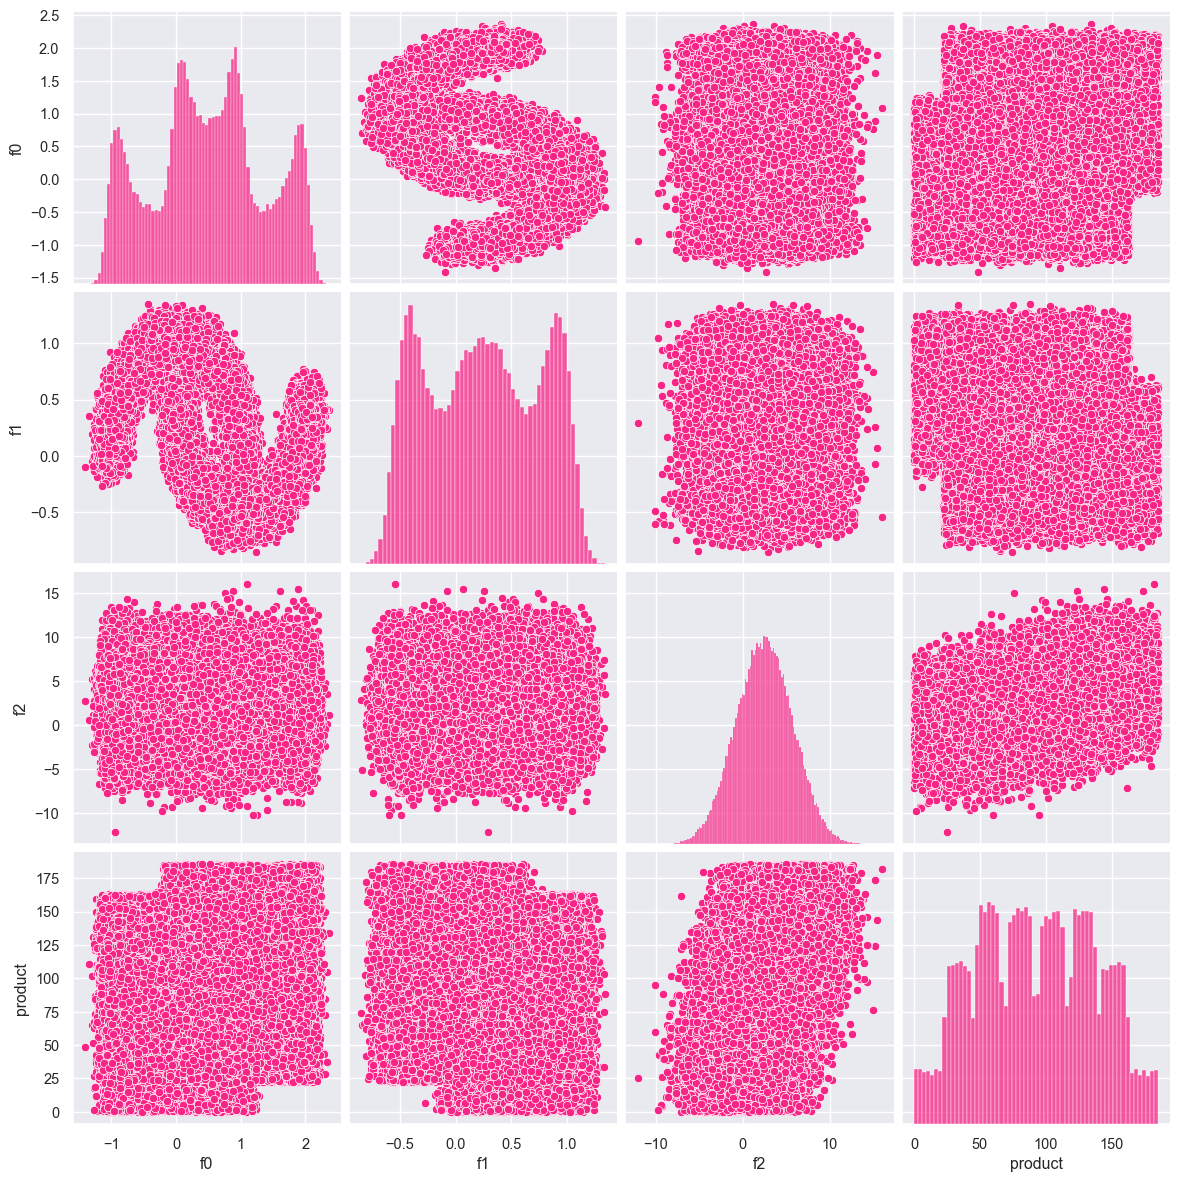

In [16]:
plot = sns.pairplot(
    geo_data_0,
    height=3,
);

Видим ленейную зависимость только между целевым признаком и `f2`.

<a id='reg1'></a>
### Регион 1

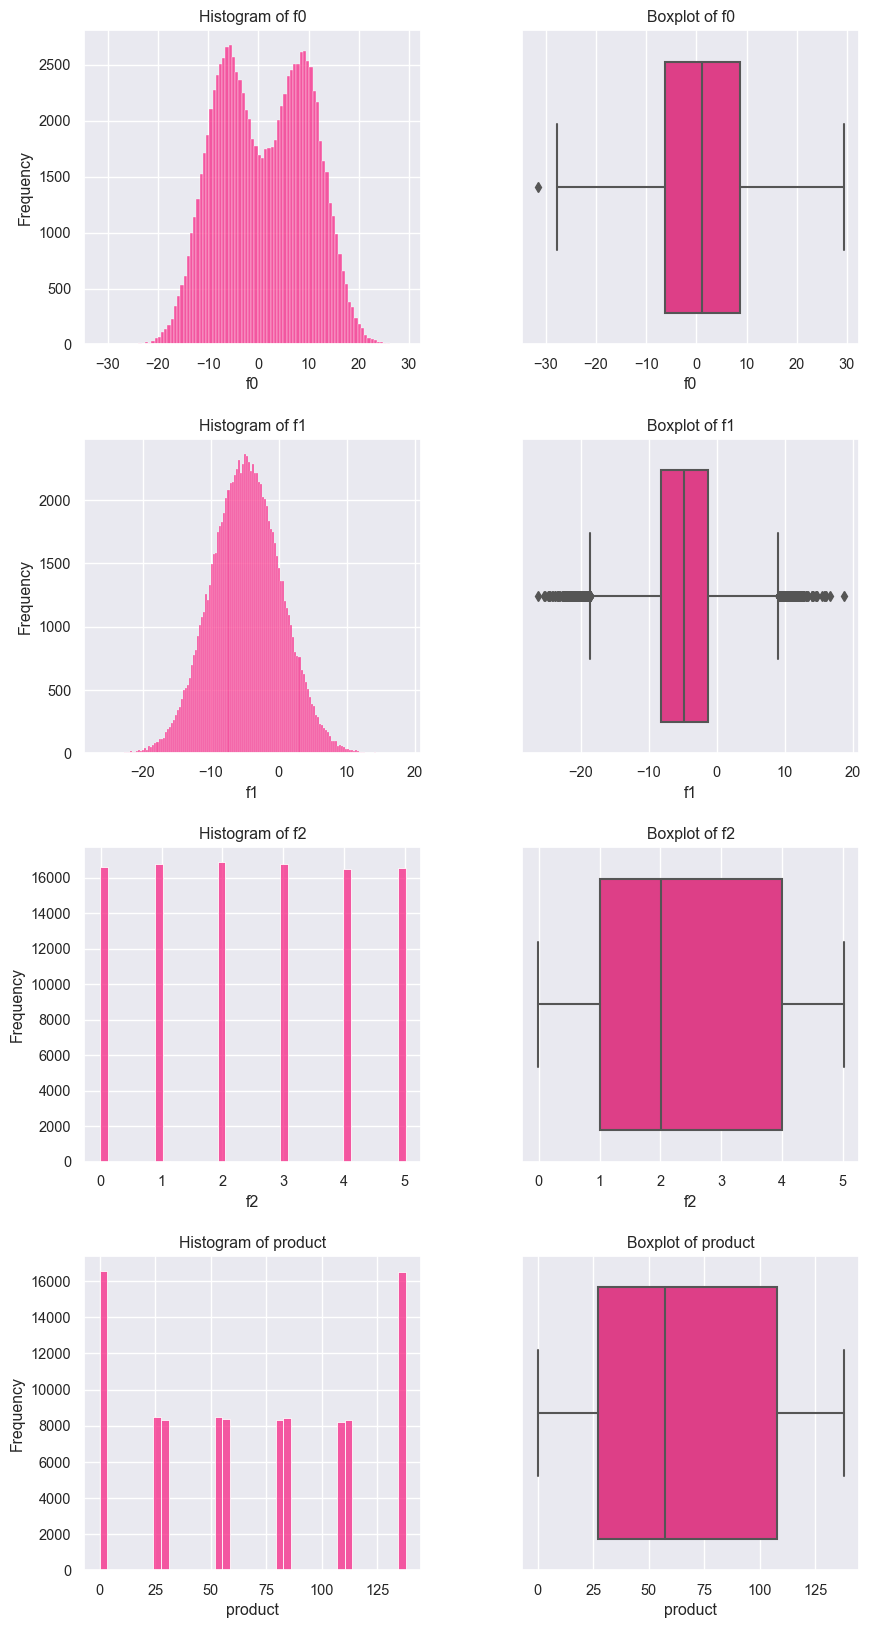

In [17]:
hist_box(geo_data_1)

В признаках `f0` и `f1` есть выбросы, только `f1` распределен нормально.

In [18]:
geo_data_1.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,99996.0,1.141209,8.965815,-31.609576,-6.298551,1.153055,8.620964,29.421755
f1,99996.0,-4.796608,5.119906,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,99996.0,2.494501,1.703579,-0.018144,1.000021,2.011475,3.999904,5.019721
product,99996.0,68.823916,45.944663,0.000000,26.953261,57.085625,107.813044,137.945408


Статистика целевого признака `product` - объём запасов в скважине (тыс. баррелей):
- Среднее: 68.82
- Медиана: 57.09
- Минимальное: 0.0
- Максимальное: 137.95

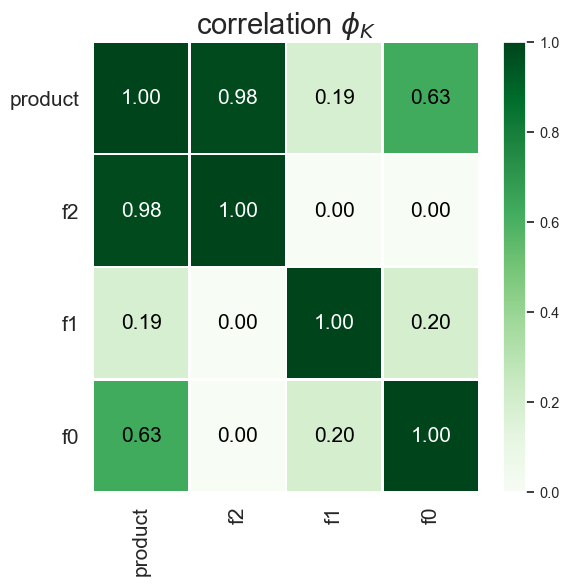

In [19]:
phik_corr(geo_data_1)

Мультиколлинеарность - сильная линейная взаимосвязь между входными признаками. О ней говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. Такой коэффициент есть между целивым признаком и признаком `f2` и составляет 0.98, значит, **мультиколлинеарность есть.** Мультиколлинеарность может привести к неустойчивости решения и переобучению модели, но удалить признак мы не может, так как не знаем причины зависимости (это может быть особенность объекта или ошибка).

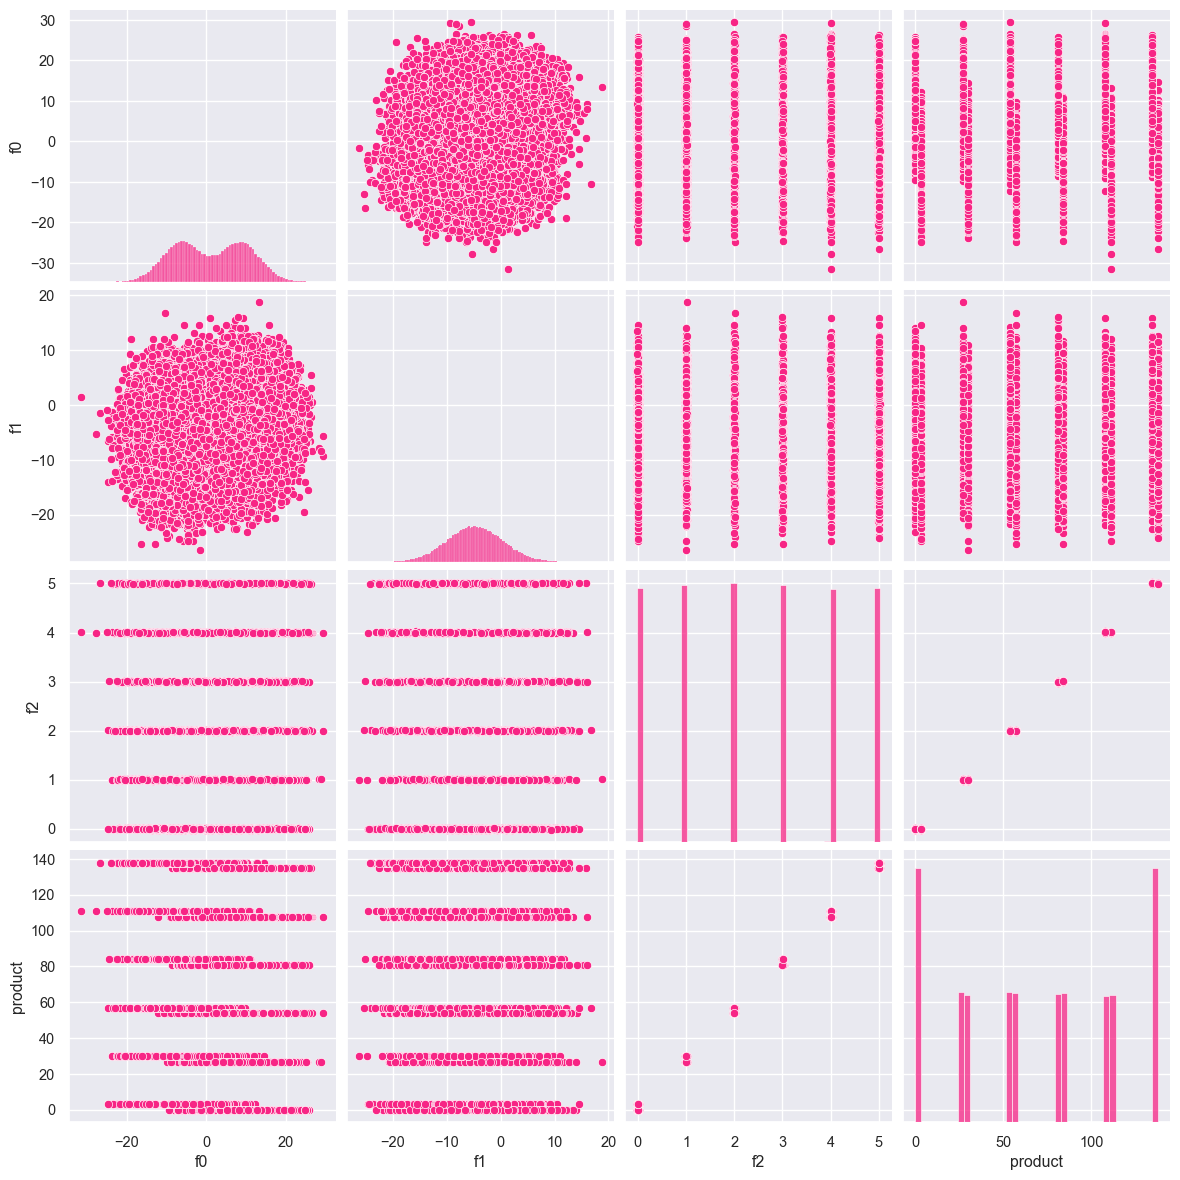

In [20]:
plot = sns.pairplot(
    geo_data_1,
    height=3,
);

Видим ленейную зависимость только между целевым и признаком `f2`.

<a id='reg2'></a>
### Регион 2

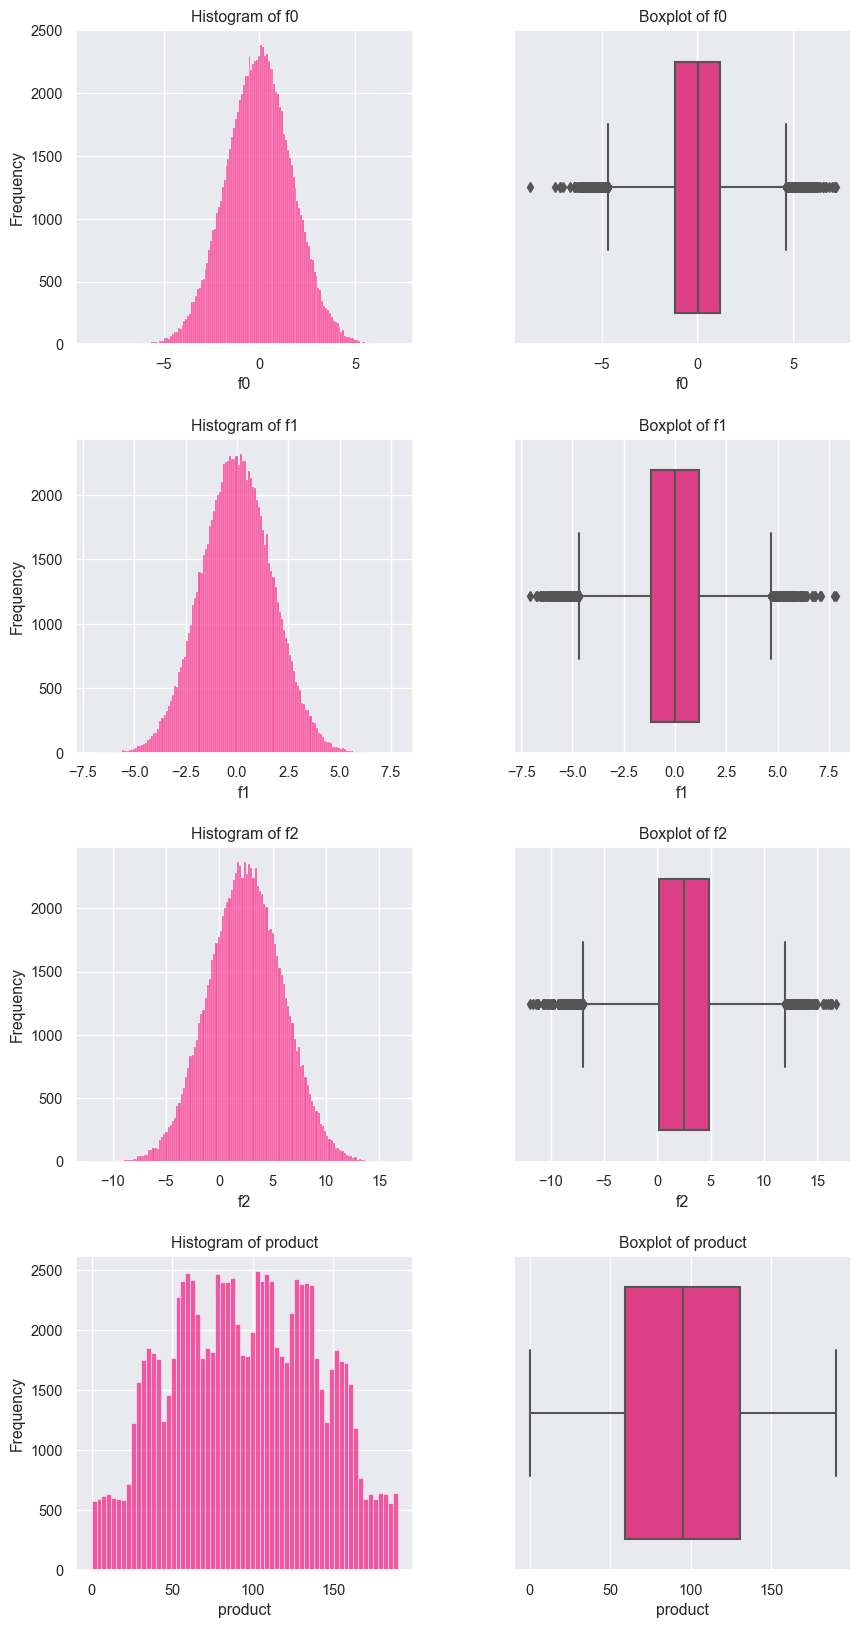

In [21]:
hist_box(geo_data_2)

Во всех признаках кроме целевого есть выбросы, признаки `f0`, `f1`, `f2` распределены нормально.

In [22]:
geo_data_2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,99996.0,0.002002,1.732052,-8.760004,-1.162328,0.009424,1.158477,7.238262
f1,99996.0,-0.002159,1.730397,-7.084020,-1.174841,-0.009661,1.163523,7.844801
f2,99996.0,2.495084,3.473482,-11.970335,0.130269,2.484236,4.858720,16.739402
product,99996.0,94.998342,44.749573,0.000000,59.450028,94.925026,130.586815,190.029838


Статистика целевого признака `product` - объём запасов в скважине (тыс. баррелей):
- Среднее: 95.00
- Медиана: 94.93
- Минимальное: 0.0
- Максимальное: 190.03

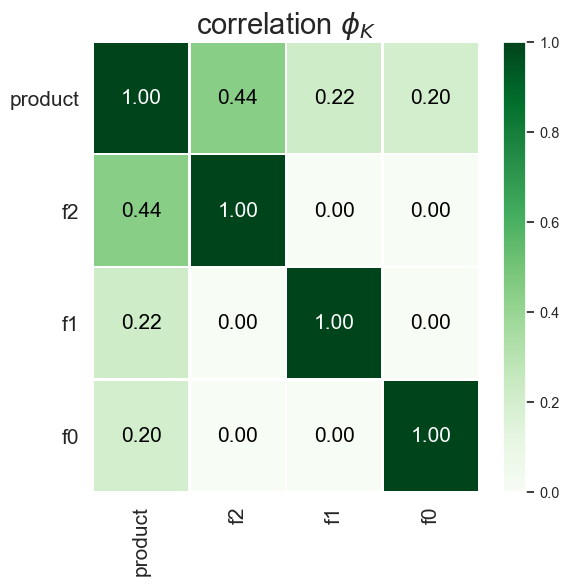

In [23]:
phik_corr(geo_data_2)

Мультиколлинеарность - сильная линейная взаимосвязь между входными признаками. О ней говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. Таких коэффициентов в данной выборке нет, значит, **мультиколлинеарности нет.**

Больше всего целевой признак коррелирует с `f2`, коэффициент корреляции равен 0.44.

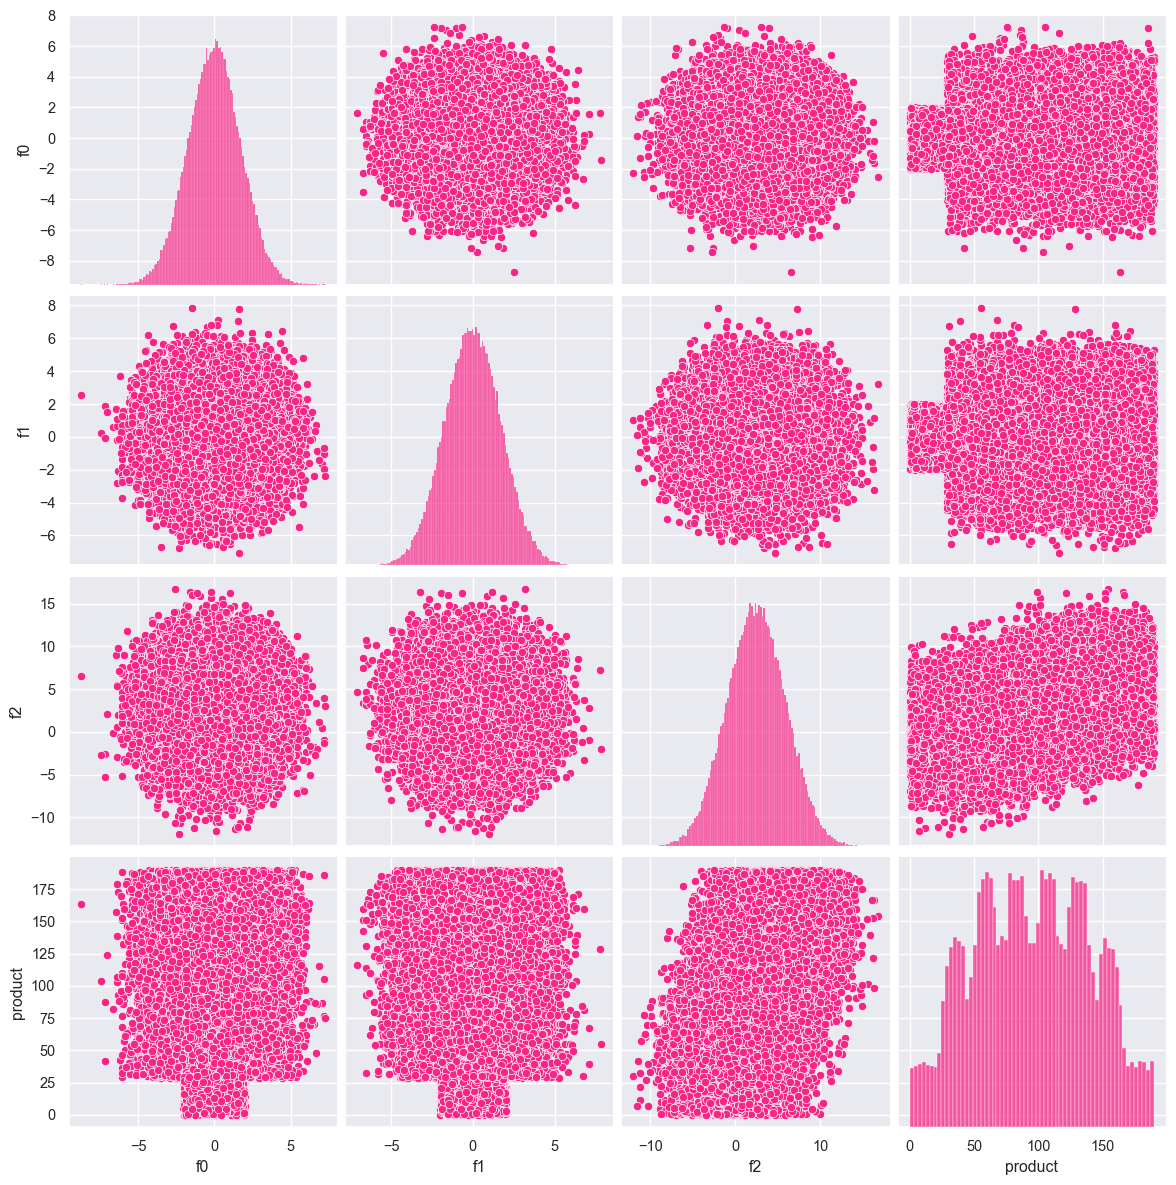

In [24]:
plot = sns.pairplot(
    geo_data_2,
    height=3,
);

Видим ленейную зависимость только между целевым признаком и `f2`.

**Общий вывод исследовательского анализа:**
- **Регион 0**
    - В признаке `f2` есть выбросы, только `f2` распределен нормально.
    - Статистика целевого признака `product` - объём запасов в скважине (тыс. баррелей):
        - **Среднее:** 92.50
        - **Медиана:** 91.85
        - **Минимальное:** 0.0
        - **Максимальное:** 185.36
    - **Мультиколлинеарности нет.** Больше всего целевой признак коррелирует с `f2`, коэффициент корреляции равен 0.48.
    - Видим ленейную зависимость только между целевым признаком и `f2`.


- **Регион 1**
    - В признаках `f0` и `f1` есть выбросы, только `f1` распределен нормально.
    - Статистика целевого признака `product` - объём запасов в скважине (тыс. баррелей):
        - **Среднее:** 68.82
        - **Медиана:** 57.09
        - **Минимальное:** 0.0
        - **Максимальное:** 137.95
    - **Мультиколлинеарность есть.** Мультиколлинеарность может привести к неустойчивости решения и переобучению модели, но удалить признак мы не может, так как не знаем причины зависимости (это может быть особенность объекта или ошибка). Больше всего целевой признак коррелирует с `f2`, коэффициент корреляции равен 0.98.
    - Видим ленейную зависимость только между целевым и признаком `f2`.


- **Регион 2**
    - Во всех признаках кроме целевого есть выбросы, признаки `f0`, `f1`, `f2` распределены нормально.
    - Статистика целевого признака `product` - объём запасов в скважине (тыс. баррелей):
        - **Среднее:** 95.00
        - **Медиана:** 94.93
        - **Минимальное:** 0.0
        - **Максимальное:** 190.03
    - **Мультиколлинеарности нет.** Больше всего целевой признак коррелирует с `f2`, коэффициент корреляции равен 0.44.
    - Видим ленейную зависимость только между целевым признаком и `f2`.

<a id='mod'></a>
## Обучение моделей

In [25]:
def predict_product(df):
    # разбиваем данные на выборки
    X = df.drop(['product', 'id'], axis=1)
    y =  df['product']
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE
    )
    
    # создаем переменную с экземпляром класса StandardScaler()
    scaler = StandardScaler()
    
    # обучаем и трансформируем признаки из тренировочной выборки
    X_train_scaled = scaler.fit_transform(X_train)
    # выполняем преобразование признаков в тестовой выборке
    X_test_scaled = scaler.transform(X_test)   
    
    # обучаем модель линейной регрессии и получаем предсказания
    model_lr  = LinearRegression()
    model_lr.fit(X_train_scaled, y_train)
    pred_y = model_lr.predict(X_test_scaled)
    
    # считаем метрику rmse
    rmse = mean_squared_error(y_test, pred_y, squared=False)
    
    return y_test, pred_y, rmse

In [26]:
y_true_0, y_pred_0, rmse_score_0 = predict_product(geo_data_0)
print('Регион 0:\n', 'RMSE:', round(rmse_score_0, 2), \
     '\n Средний запас предсказанного сырья:', round(y_pred_0.mean(), 2))

y_true_1, y_pred_1, rmse_score_1 = predict_product(geo_data_1)
print('\nРегион 1:\n', 'RMSE:', round(rmse_score_1, 2), \
     '\n Средний запас предсказанного сырья:', round(y_pred_1.mean(), 2))

y_true_2, y_pred_2, rmse_score_2 = predict_product(geo_data_2)
print('\nРегион 2:\n', 'RMSE:', round(rmse_score_2, 2), \
     '\n Средний запас предсказанного сырья:', round(y_pred_2.mean(), 2))

Регион 0:
 RMSE: 37.67 
 Средний запас предсказанного сырья: 92.57

Регион 1:
 RMSE: 0.89 
 Средний запас предсказанного сырья: 69.02

Регион 2:
 RMSE: 40.11 
 Средний запас предсказанного сырья: 95.02


**Вывод:** 
Наибольший средний запас предсказанного сырья находится в **регионе 2** (95.02), а наименьший в **регионе 1** (69.02).

Лучший показатель корня среднеквадратической ошибки у **региона 1** (0.89), это можно объяснить мультиколлинеарностью между признаками. Худший показатель RMSE у **региона 2**, скорее всего, из-за выбросов в данных.

<a id='prof'></a>
## Расчет прибыли

Подготовим данные к расчету прибыли: сохраним все ключевые значения для расчетов в отдельные переменные.

In [27]:
# кол-во точек в регионе для исследования
MAX_LOCATIONS = 500
# кол-во лучших точек для разработки
BEST_LOCATIONS = 200
# бюджет на разработку скважин
BUDGET = 10000000000
# доход с кажой единицы продукта
REVENUE = 450000
# вероятность убытков
LOSS_PROB = 0.025

# достаточный объём сырья для безубыточной разработки новой скважины
sufficient_vol = BUDGET / BEST_LOCATIONS / REVENUE
print('Достаточный объём сырья равен', round(sufficient_vol, 2))

Достаточный объём сырья равен 111.11


**Вывод:** Достаточный объём сырья для безубыточной разработки новой скважины превышает средний запас предсказанного сырья во всех трех районах. `111 тысяч баррелей` - минимальный объем для безубыточной разработки, самый большой предсказанный средний объем сырья составляет `95 тысяч баррелей`.

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [28]:
def calculate_profit(target, preditions):
    probs_sorted = preditions.sort_values(ascending=False)
    selected = target[probs_sorted.index][:BEST_LOCATIONS]
    return selected.sum() * REVENUE - BUDGET

In [29]:
region_0 = calculate_profit(
    y_true_0, 
    pd.Series(y_pred_0, index=y_true_0.index))

region_1 = calculate_profit(
    y_true_1, 
    pd.Series(y_pred_1, index=y_true_1.index))

region_2 = calculate_profit(
    y_true_2, 
    pd.Series(y_pred_2, index=y_true_2.index))

In [30]:
print('Прибыль региона 0:', f'{region_0/1e6:.2f} млн.руб.')
print('Прибыль региона 1:', f'{region_1/1e6:.2f} млн.руб.')
print('Прибыль региона 2:', f'{region_2/1e6:.2f} млн.руб.')

Прибыль региона 0: 3332.20 млн.руб.
Прибыль региона 1: 2415.09 млн.руб.
Прибыль региона 2: 2065.18 млн.руб.


Самый прибыльный - `регион 0`, наименее прибыльный - `регион 2`.

Посчитаем риски и прибыль для каждого региона. Используем Bootstrap с 1000 выборок, чтобы найти распределение прибыли, и найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. 

In [31]:
# функция подсчета доверительного интервала и риска убытков
def conf_interval(target, preditions):
    state = np.random.RandomState(12345)
    values=[]
    
    # перебираем выборки и считаем прибыль
    for i in range(1000):
        target_sample = target.sample(
            replace=True,
            random_state=state, 
            n=MAX_LOCATIONS)

        pred_sample = preditions[target_sample.index]
        values.append(calculate_profit(target_sample, pred_sample))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = (values < 0).mean() * 100
    
    # строим график
    plt.figure(figsize=(6, 5))
    sns.histplot(data=values, alpha=0.5)
    plt.xlabel('Прибыль региона')
    plt.axvline(x=mean, color='navy',
                ls='-', lw=2, label='Средняя прибыль')
    plt.axvline(x=lower, color='blue', 
                ls=':', lw=3, label='95%-й доверительный интервал')
    plt.axvline(x=upper, color='blue', 
                ls=':', lw=3)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.show()
    
    # выводим значения
    print('Средняя прибыль:', f'{mean/1e6:.2f} млн.руб.')
    print('Риск:',f'{risk:.2f}%')
    print('Доверительный интервал', 
          f'[{lower/1e6:.2f} млн.руб. : {upper/1e6:.2f} млн.руб.]')

<a id='reg00'></a>
### Регион 0

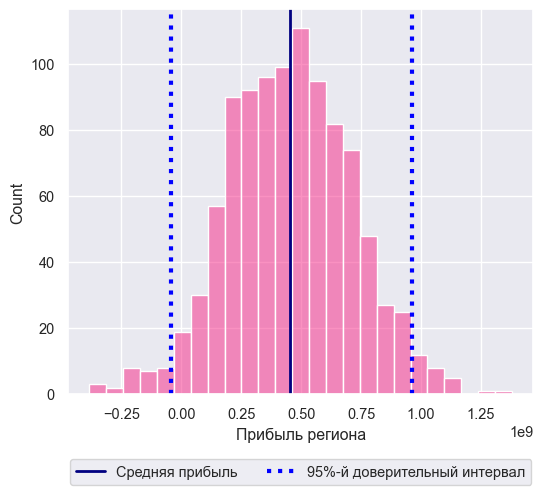

Средняя прибыль: 454.16 млн.руб.
Риск: 3.70%
Доверительный интервал [-43.14 млн.руб. : 961.86 млн.руб.]


In [32]:
conf_interval(y_true_0, pd.Series(y_pred_0, index=y_true_0.index))

<a id='reg01'></a>
### Регион 1

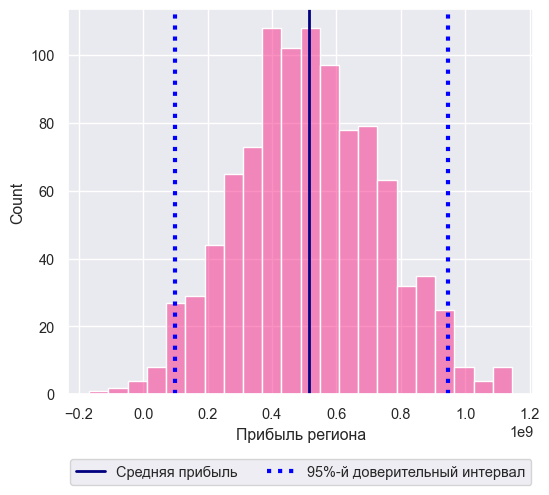

Средняя прибыль: 516.51 млн.руб.
Риск: 0.60%
Доверительный интервал [100.23 млн.руб. : 947.22 млн.руб.]


In [33]:
conf_interval(y_true_1, pd.Series(y_pred_1, index=y_true_1.index))

<a id='reg02'></a>
### Регион 2

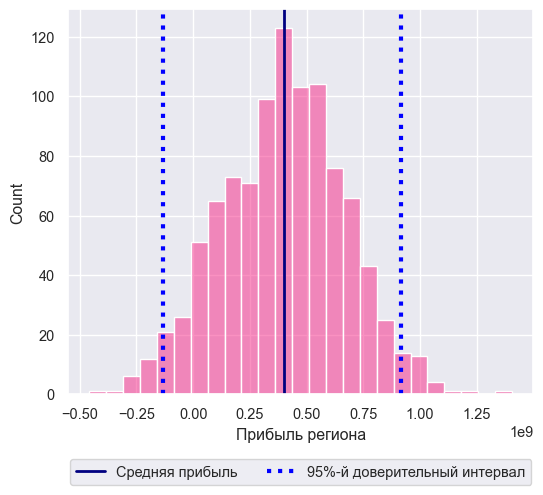

Средняя прибыль: 398.62 млн.руб.
Риск: 7.30%
Доверительный интервал [-133.94 млн.руб. : 914.44 млн.руб.]


In [34]:
conf_interval(y_true_2, pd.Series(y_pred_2, index=y_true_2.index))

**Вывод:** 
- Достаточный объём сырья для безубыточной разработки новой скважины равен `111 тысяч баррелей` и он превышает предсказанные средние значения объема сырья в каждом регионе (самый большой большой по объему регион - **регион 2** имеет запас `95 тысяч баррелей`. То есть ни один регион не является безубыточным.


**Регион 0:**
- **Средняя прибыль:** 454.16 млн.руб.
- **Риск:** 3.70%
- **Доверительный интервал:** [-43.14 млн.руб. : 961.86 млн.руб.]

**Регион 1:**
- **Средняя прибыль:** 516.51 млн.руб.
- **Риск:** 0.60%
- **Доверительный интервал:** [100.23 млн.руб. : 947.22 млн.руб.]

**Регион 2:**
- **Средняя прибыль:** 398.62 млн.руб.
- **Риск:** 7.30%
- **Доверительный интервал:** [-133.94 млн.руб. : 914.44 млн.руб.]


Если смотреть по `200` скважинам с лучшим объемом, то самый прибыльный - **регион 0** (`3332.20 млн.руб`), наименее прибыльный - **регион 2** (`2065.18 млн.руб`). Меньше всего рисков и больше прибыли в **регионе 1**, он является приоритетным для разработки. **Регионы 0 и 2** могут быть убыточными. Но следует обратить внимание на **регион 0**, он может оказаться прибыльным, если найти способ сократить риски (исследовать регион подробнее, добавить новые признаки, построить более точную модель предсказания скважин). 

<a id='fin'></a>
## Общие выводы

**Цели проекта выполнены:** 
- Проанализированы характеристики для скважин в избранном регионе: качество нефти и объём её запасов;
- Построена модель для предсказания объёма запасов в новых скважинах;
- Выбраны скважины с самыми высокими оценками значений;
- Определен регион с максимальной суммарной прибылью отобранных скважин.

**Исходные данные:**
- Данные геологоразведки трёх регионов, находящиеся в файлах: 
    - `/datasets/geo_data_0.csv`.
    - `/datasets/geo_data_1.csv`.
    - `/datasets/geo_data_2.csv`.
    
- Содержащие следующие признаки:
    - `id` — уникальный идентификатор скважины;
    - `f0`, `f1`, `f2` — три признака точек;
    - `product` — объём запасов в скважине (тыс. баррелей).

**В ходе выполнения работы проделаны следующие шаги:**
- Загружены и проверены соответствия данных в датафреймах;
- В результате **предобработки данных** удалены дубликаты:
    - Внутри каждого датафрейма присутствуют дубликаты по `id` некоторых скажин, следует проверить где ошибка. 
- В ходе **исследовательского анализа данных** получены следующие данные:
--------------------------------------------------------------------------
**Регион 0**
   - В признаке `f2` есть выбросы, только `f2` распределен нормально.
   - Статистика целевого признака `product` - объём запасов в скважине (тыс. баррелей):
        - **Среднее:** 92.50
        - **Медиана:** 91.85
        - **Минимальное:** 0.0
        - **Максимальное:** 185.36
   - **Мультиколлинеарности нет.** Больше всего целевой признак коррелирует с `f2`, коэффициент корреляции равен 0.48.
   - Видим ленейную зависимость только между целевым признаком и `f2`.


**Регион 1**
   - В признаках `f0` и `f1` есть выбросы, только `f1` распределен нормально.
   - Статистика целевого признака `product` - объём запасов в скважине (тыс. баррелей):
        - **Среднее:** 68.82
        - **Медиана:** 57.09
        - **Минимальное:** 0.0
        - **Максимальное:** 137.95
   - **Мультиколлинеарность есть.** Мультиколлинеарность может привести к неустойчивости решения и переобучению модели, но удалить признак мы не может, так как не знаем причины зависимости (это может быть особенность объекта или ошибка). Больше всего целевой признак коррелирует с `f2`, коэффициент корреляции равен 0.98.
   - Видим ленейную зависимость только между целевым и признаком `f2`.


**Регион 2**
   - Во всех признаках кроме целевого есть выбросы, признаки `f0`, `f1`, `f2` распределены нормально.
   - Статистика целевого признака `product` - объём запасов в скважине (тыс. баррелей):
        - **Среднее:** 95.00
        - **Медиана:** 94.93
        - **Минимальное:** 0.0
        - **Максимальное:** 190.03
   - **Мультиколлинеарности нет.** Больше всего целевой признак коррелирует с `f2`, коэффициент корреляции равен 0.44.
   - Видим ленейную зависимость только между целевым признаком и `f2`.
--------------------------------------------------------------------------
- Обучены модели для каждого региона и получены следующие выводы: 
    - Наибольший средний запас предсказанного сырья находится в **регионе 2** (95.02), а наименьший в **регионе 1** (69.02).
    - Лучший показатель корня среднеквадратической ошибки у **региона 1** (0.89), это можно объяснить мультиколлинеарностью между признаками. Худший показатель RMSE у **региона 2**, скорее всего, из-за выбросов в данных.

- Расчитана прибыль и оценены риски: 
    - Достаточный объём сырья для безубыточной разработки новой скважины равен `111 тысяч баррелей` и он превышает предсказанные средние значения объема сырья в каждом регионе (самый большой большой по объему регион - **регион 2** имеет запас `95 тысяч баррелей`. То есть ни один регион не является безубыточным.
--------------------------------------------------------------------------
**Регион 0:**
- **Средняя прибыль:** 454.16 млн.руб.
- **Риск:** 3.70%
- **Доверительный интервал:** [-43.14 млн.руб. : 961.86 млн.руб.]

**Регион 1:**
- **Средняя прибыль:** 516.51 млн.руб.
- **Риск:** 0.60%
- **Доверительный интервал:** [100.23 млн.руб. : 947.22 млн.руб.]

**Регион 2:**
- **Средняя прибыль:** 398.62 млн.руб.
- **Риск:** 7.30%
- **Доверительный интервал:** [-133.94 млн.руб. : 914.44 млн.руб.]
--------------------------------------------------------------------------
Если смотреть по `200` скважинам с лучшим объемом, то самый прибыльный - **регион 0** (`3332.20 млн.руб`), наименее прибыльный - **регион 2** (`2065.18 млн.руб`). Меньше всего рисков и больше прибыли в **регионе 1**, он является приоритетным для разработки. **Регионы 0 и 2** могут быть убыточными. Но следует обратить внимание на **регион 0**, он может оказаться прибыльным, если найти способ сократить риски (исследовать регион подробнее, добавить новые признаки, построить более точную модель предсказания скважин). 

[Наверх][1]

[1]:#task